In [17]:
# importing libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter, ScalarOutcome, TimeSeriesOutcome)
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking
from ema_workbench.analysis import feature_scoring
from ema_workbench import save_results
from ema_workbench import load_results

# Model definition and instantiation 

The model is defined in the Model.py file. Below the model is imported and connected to the EMA workbench. This includes defining interventions (levers), uncertainties, and outcomes.

In [2]:
# define interventions
p0 = {'cash_transfer': 0, 'vouchers': 0, 'info_campaign': 0, 'maintenance_capacity': 0}

p1 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 0, 'maintenance_capacity': 0}
p2 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 5, 'maintenance_capacity': 0}
p3 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 0, 'maintenance_capacity': 5}
p4 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 5, 'maintenance_capacity': 5}

p5 = {'cash_transfer':0, 'vouchers': 4000, 'info_campaign': 0, 'maintenance_capacity': 0}
p6 = {'cash_transfer':0, 'vouchers': 4000, 'info_campaign': 5, 'maintenance_capacity': 0}
p7 = {'cash_transfer': 0, 'vouchers': 4000, 'info_campaign': 0, 'maintenance_capacity': 5}
p8 = {'cash_transfer':0, 'vouchers': 4000, 'info_campaign': 5, 'maintenance_capacity': 5}

# choose one intervention for the experiments
p = p1

In [3]:
# import the model and define function to create and run the model, needed as input for EMA workbench
from Model import DiffusionModel, Household
seed1 = 44
np.random.seed(seed1)

# define function with default input parameter values
def diffusion_model(seed = seed1, initial_adopters =  0.025, cash_transfer = p['cash_transfer'], vouchers= p['vouchers'], 
                    info_campaign = p['info_campaign'], maintenance_capacity=p['maintenance_capacity'], 
                    N=380, avg_node_degree=6, p_rewiring=0.2, r_discount=0.1, atp=0.035, p_bad_performance=0.01, 
                    p_imitators=0.0, p_optimizers=0.0, p_advice_seekers=0.0, p_supply_delay = 0, price_tf=1500, 
                    price_cf=6000, price_shock = 0, n_cf_price_shock = 0, steps=150):
    
    model = DiffusionModel(seed, initial_adopters, cash_transfer, vouchers, info_campaign, maintenance_capacity, 
                            N, avg_node_degree, p_rewiring, r_discount, atp, p_bad_performance, p_imitators, p_optimizers, 
                            p_advice_seekers, p_supply_delay, price_tf, price_cf, price_shock, n_cf_price_shock)
    
    # run the model for 150 steps
    model.run_model(steps)
    data = model.datacollector.get_model_vars_dataframe().reset_index()
    
    return data.iloc[-1].Adoption, data.Adoption, data.Rejection, data.Ignorance, data.Decision, data.Awareness

In [58]:
# instantiate the model
model = Model('diffusion', function=diffusion_model)

# specify uncertainties for set 1, and optional uncertainties for set 2 and 3 
model.uncertainties = [RealParameter('p_bad_performance', 0, 0.02),
                        RealParameter('atp', 0, 0.05),
                        RealParameter('r_discount', 0.0, 0.1),
                        IntegerParameter('avg_node_degree', 4, 12),
                        RealParameter('p_rewiring', 0.1, 0.9)]
#                        RealParameter('price_shock', -0.2, 0.2),
#                        IntegerParameter('n_cf_price_shock', 0, 6),
#                         RealParameter('p_supply_delay', 0, 0.02),
#                         RealParameter('p_advice_seekers', 0, 0.25),
#                          RealParameter('p_optimizers', 0, 0.25),
#                         RealParameter('p_imitators', 0, 0.25)]


# specify outcomes - here: number of final adopers, and number of agents in each of the five stages
# the remaining KPIs (timeliness and robustness) are calculated based on the number of adopters over time
model.outcomes = [ScalarOutcome('Final number of adopters'),
                  TimeSeriesOutcome('Adoption'),
                  TimeSeriesOutcome('Rejection'),
                  TimeSeriesOutcome('Ignorance'),
                  TimeSeriesOutcome('Decision'),
                  TimeSeriesOutcome('Awareness')]

# Experimentation

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 2000

# choose sequential or multiprocessing evaluator 
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios)

# with MultiprocessingEvaluator(model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(n_scenarios)

# optional: saving of the results
# results = experiments, outcomes
# save_results(results, 'Results/final 2000 scenarios p3 base0025ini 380.tar.gz')

In [12]:
# loading the results
# experiments, outcomes = load_results('Results/final 2000 scenarios p1 base0025ini 380.tar.gz')
# experiments0, outcomes0 = load_results('Results/final 2000 scenarios p0 base0025ini 380.tar.gz')
# experiments1, outcomes1 = load_results('Results/final 2000 scenarios p1 base0025ini 380.tar.gz')
# experiments2, outcomes2 = load_results('Results/final 2000 scenarios p2 base0025ini 380.tar.gz')
# experiments3, outcomes3 = load_results('Results/final 2000 scenarios p13 base0025ini 380.tar.gz')
# experiments4, outcomes4 = load_results('Results/final 2000 scenarios p3 base0025ini 380.tar.gz')
# experiments5, outcomes5 = load_results('Results/final 2000 scenarios p4 base0025ini 380.tar.gz')
# experiments6, outcomes6 = load_results('Results/final 2000 scenarios p5 base0025ini 380.tar.gz')
# experiments7, outcomes7 = load_results('Results/final 2000 scenarios p14 base0025ini 380.tar.gz')
# experiments8, outcomes8 = load_results('Results/final 2000 scenarios p6 base0025ini 380.tar.gz')
# experiments00, outcomes00 = load_results('Results/final 5000 scenarios p3 shocks0025ini 380.tar.gz')
# experiments01, outcomes01 = load_results('Results/final 5000 scenarios p6 shocks0025ini 380.tar.gz')
# experiments02, outcomes02 = load_results('Results/5000 scenarios p3 decision0025ini 380.tar.gz')
# experiments03, outcomes03 = load_results('Results/5000 scenarios p6 decision0025ini 380.tar.gz')

# Data analysis

The data analysis comprises three parts:
1. Plotting the adoption curves over time,
1. Creating boxplots to display the KPIs (long-term impact, timeliness), robustness is calculated separately, not using boxplots,
1. Exploratory analysis (PRIM).

Note: The data analysis included in this notebook exemplifies some of the analyses performed in the MSc thesis. 


## Number of adopters over time

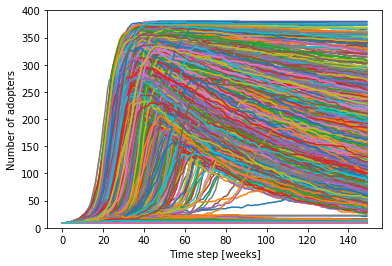

In [95]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    if outcome == 'Adoption':
        plotting.lines(experiments, outcomes, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [weeks]')
plt.ylabel('Number of adopters')
plt.ylim(0, 400)
plt.show()

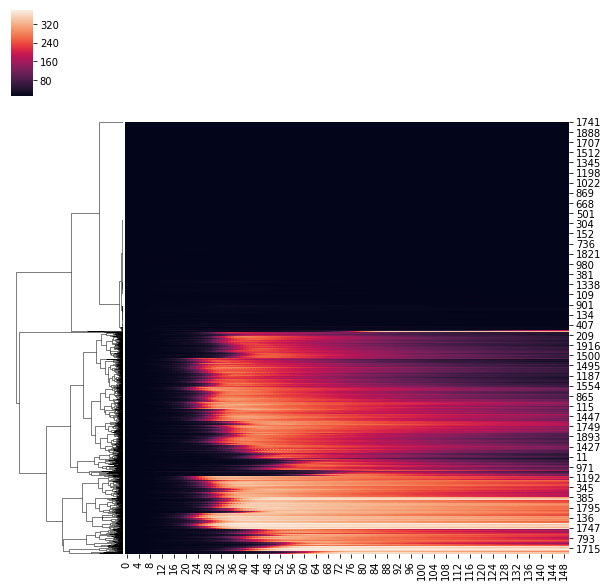

In [96]:
# some first analysis of the adoption curves over time by clustering
sns.clustermap(pd.DataFrame(outcomes['Adoption']), col_cluster=False);

## Boxplots

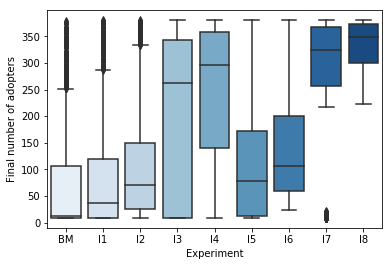

In [16]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8'], 
            y=[outcomes0['Final number of adopters'], 
            outcomes1['Final number of adopters'], 
            outcomes2['Final number of adopters'], 
            outcomes3['Final number of adopters'],
            outcomes4['Final number of adopters'], 
            outcomes5['Final number of adopters'],
            outcomes6['Final number of adopters'], 
            outcomes7['Final number of adopters'],   
            outcomes8['Final number of adopters']], 
            palette = 'Blues')
plt.ylabel('Final number of adopters')
plt.xlabel('Experiment')
plt.show()

In [17]:
# calculate time to reach the maximum adoption level - note: only for the outcomes above the 75th percentile to reduce bias created by the runs which do not increase (significantly)
timing0 = outcomes0['Adoption'][outcomes0['Final number of adopters'] > np.percentile(outcomes0['Final number of adopters'], 75)][:400]
timing1 = outcomes1['Adoption'][outcomes1['Final number of adopters'] > np.percentile(outcomes1['Final number of adopters'], 75)][:400]
timing2 = outcomes2['Adoption'][outcomes2['Final number of adopters'] > np.percentile(outcomes2['Final number of adopters'], 75)][:400]
timing3 = outcomes3['Adoption'][outcomes3['Final number of adopters'] > np.percentile(outcomes3['Final number of adopters'], 75)][:400]
timing4 = outcomes4['Adoption'][outcomes4['Final number of adopters'] > np.percentile(outcomes4['Final number of adopters'], 75)][:400]
timing5 = outcomes5['Adoption'][outcomes5['Final number of adopters'] > np.percentile(outcomes5['Final number of adopters'], 75)][:400]
timing6 = outcomes6['Adoption'][outcomes6['Final number of adopters'] > np.percentile(outcomes6['Final number of adopters'], 75)][:400]
timing7 = outcomes7['Adoption'][outcomes7['Final number of adopters'] > np.percentile(outcomes7['Final number of adopters'], 75)][:400]
timing8 = outcomes8['Adoption'][outcomes8['Final number of adopters'] > np.percentile(outcomes8['Final number of adopters'], 75)][:400]

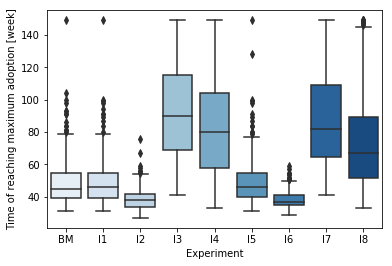

In [19]:
sns.boxplot(x = ['BM', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8'], 
            y=[np.argmax(timing0, axis=1),
               np.argmax(timing1, axis=1),
               np.argmax(timing2, axis=1),
               np.argmax(timing3, axis=1),
               np.argmax(timing4, axis=1),
               np.argmax(timing5, axis=1),
               np.argmax(timing6, axis=1),
               np.argmax(timing7, axis=1),
               np.argmax(timing8, axis=1)],
            palette = 'Blues' )
               
plt.ylabel('Time of reaching maximum adoption [week]')
plt.xlabel('Experiment')
plt.show()

## Exploratory analysis 

In [111]:
# define outcomes of interest - here: success above 75th percentile, or failure below 25th percentile
# PRIM for p4 with shocks
final_adoption =  outcomes00['Final number of adopters']
y = final_adoption > np.percentile(final_adoption, 75)

# apply PRIM algorithm to map outcomes of interest to sub-spaces in uncertainty space (scenarios)
prim_alg = prim.Prim(experiments00, y, threshold=0.8, peel_alpha = 0.1)
box1 = prim_alg.find_box()

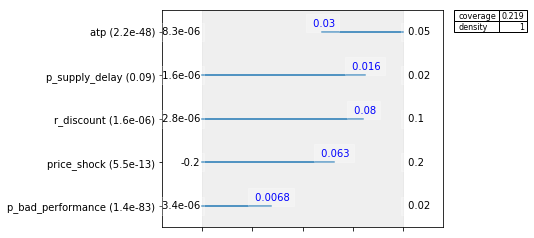

In [110]:
# plotting the parameter ranges found by PRIM
box1.inspect(style='graph')
plt.show()

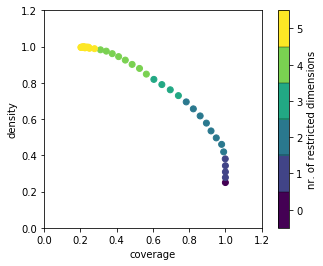

In [112]:
# plotting the trade-off curve between coverage and density 
box1.show_tradeoff()
plt.show()

In [8]:
# PRIM for p8 with shocks
final_adoption01 =  outcomes01['Final number of adopters']
y01 = final_adoption01 > np.percentile(final_adoption01, 75)

# apply PRIM algorithm to map outcomes of interest to sub-spaces in uncertainty space (scenarios)
prim_alg = prim.Prim(experiments01, y01, threshold=0.8, peel_alpha = 0.2)
box2 = prim_alg.find_box()

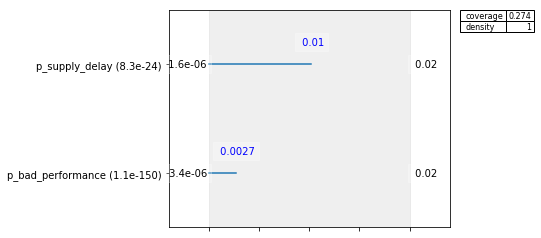

In [9]:
# plotting the parameter ranges found by PRIM
box2.inspect(style='graph')
plt.show()

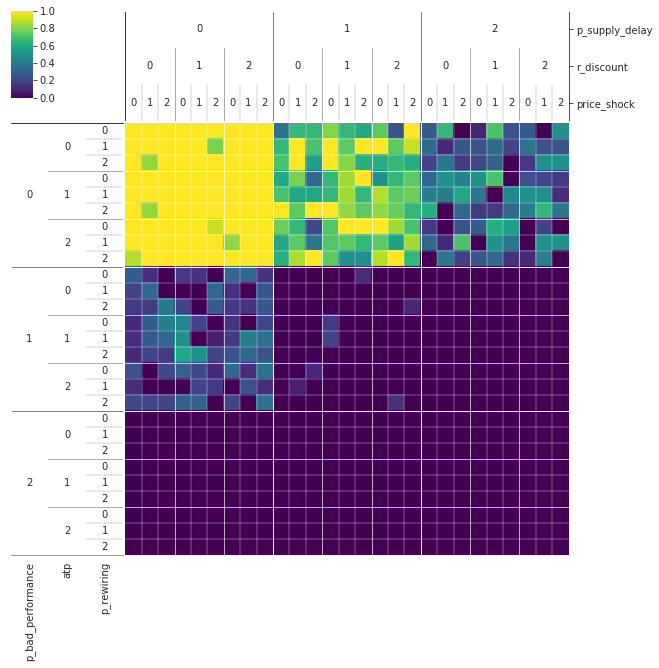

In [11]:
# dimensional stacking helped to check whether the uncertainty space has been sufficiently sampled (5000 scenarios)
dimensional_stacking.create_pivot_plot(experiments01, y01)
plt.show()

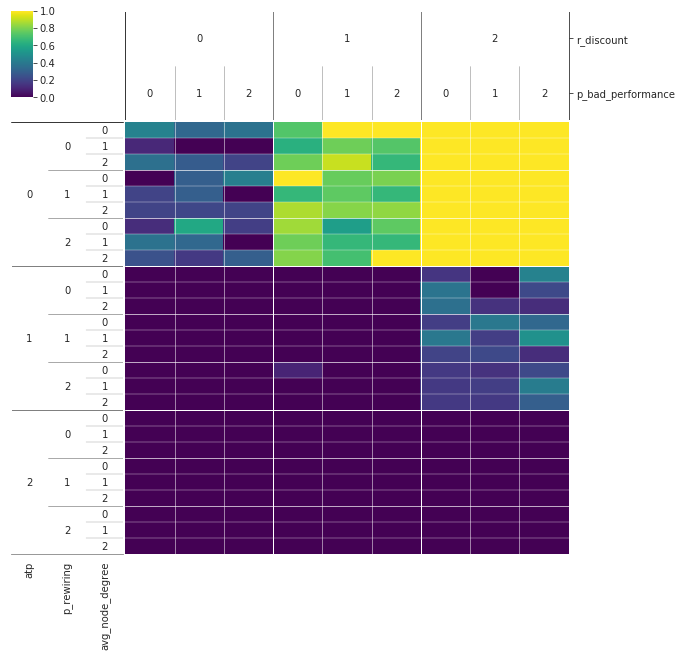

In [16]:
# dimensional stacking for p4 and 2000 scenarios
final_adoption4 =  outcomes4['Final number of adopters']
y4 = final_adoption4 < np.percentile(final_adoption4, 25)
dimensional_stacking.create_pivot_plot(experiments4, y4)
plt.show()